In [1]:
import numpy as np
import wave
import librosa
import librosa.display
from librosa.core import stft
import matplotlib.pyplot as plt
import scipy 
import matplotlib.cm as cm

In [2]:
def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.fromstring(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result


def readwav(file):
    """
    Read a wav file.
    Returns the frame rate, sample width (in bytes) and a numpy array
    containing the data.
    This function does not read compressed wav files.
    """
    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, sampwidth, array

In [204]:
audio = readwav('/users/josephcleveland/Desktop/BeepBoop.wav')[2]
print(audio.T[0])
audio = audio.astype(np.floating)
print(audio.shape)



[0 0 0 ... 0 0 0]
(229411, 1)


/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


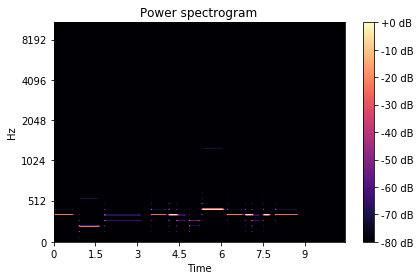

In [205]:
numBins = 2048

Spectogram = np.abs(librosa.feature.melspectrogram(audio.T[0], n_mels=numBins, fmax=4096))
librosa.display.specshow(librosa.amplitude_to_db(Spectogram,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


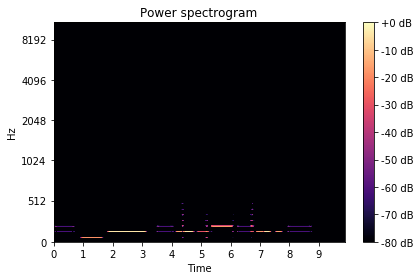

In [206]:
recaudio = readwav('/users/josephcleveland/Desktop/recreation.wav')[2]
recaudio = recaudio.astype(np.floating)


recspec = np.abs(librosa.feature.melspectrogram(recaudio.T[0], n_mels=numBins, fmax=4096))
librosa.display.specshow(librosa.amplitude_to_db(recspec,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [216]:
"""Finding frequency envelope for """

ref_freqs_bins = librosa.mel_frequencies(n_mels = numBins, fmax = 4096)
print(ref_freqs_bins[10:30])

[11.56447453 12.72092199 13.87736944 15.03381689 16.19026435 17.3467118
 18.50315925 19.65960671 20.81605416 21.97250161 23.12894907 24.28539652
 25.44184397 26.59829143 27.75473888 28.91118633 30.06763379 31.22408124
 32.38052869 33.53697615]


In [208]:
print(Spectogram.shape)
spectLength = Spectogram.shape[1]

sampRate = 44100
envStepLength = audio.shape[0]/sampRate /spectLength
print(envStepLength)

(2048, 449)
0.01158588751016368


In [209]:
"""Finding peaks"""
peaks_index = []
for i in range (0,spectLength):
    peaks_one_slice,_ = scipy.signal.find_peaks(Spectogram [:,i])
    peaks_index.append(peaks_one_slice)
print(peaks_index)

[array([   8,   18,   27,   36,   46,   55,   64,   74,   83,   92,  102,
        111,  120,  129,  139,  148,  157,  167,  176,  185,  195,  204,
        213,  223,  232,  241,  251,  260,  269,  279,  288,  297,  307,
        316,  325,  334,  344,  353,  362,  372,  381,  390,  400,  409,
        418,  428,  437,  446,  456,  465,  474,  484,  493,  502,  512,
        521,  530,  540,  549,  558,  567,  577,  586,  595,  605,  614,
        623,  633,  642,  651,  661,  670,  679,  689,  698,  707,  717,
        726,  735,  745,  754,  763,  772,  782,  791,  800,  810,  819,
        828,  838,  847,  856,  866,  875,  884,  892,  901,  910,  918,
        927,  935,  943,  951,  959,  968,  975,  983,  991,  999, 1007,
       1014, 1022, 1029, 1037, 1044, 1051, 1058, 1065, 1073, 1080, 1087,
       1093, 1100, 1107, 1114, 1121, 1127, 1134, 1140, 1147, 1153, 1160,
       1166, 1172, 1178, 1185, 1191, 1197, 1203, 1209, 1215, 1221, 1227,
       1233, 1238, 1244, 1250, 1256, 1261, 1267, 1

In [210]:
""" Find longest set of peaks, pmax"""
pmax = len(peaks_index[0])

for i in range(len(peaks_index)):
    if len(peaks_index[i]) > pmax:
        pmax = len(peaks_index[i])

In [211]:

f = open('freqs_env.csv', 'w')
for i in range (0, spectLength):
    freq = ref_freqs_bins[peaks_index[i]]
    colCount = 0
    for p in freq:
        f.write(str(p) + " ")
        colCount += 1
    for pad in range(pmax - colCount):
        f.write(str(0) + " ")
    f.write("\n")

#np.savetxt('freqs_env.csv', freqs_env, delimiter = ',', fmt='%s')

f.close()

In [212]:
        
amp_env = np.zeros((spectLength, pmax))
for i in range (0, spectLength):
    amp_one_slice = Spectogram[peaks_index[i], i]
    amp_env[i, :amp_one_slice.shape[0]] = amp_one_slice
    #amp_env.append(amp_one_slice)
    
print(amp_env[0])

[2.71871506e+06 7.95224521e+04 2.39813127e+06 6.25659305e+06
 5.57677763e+06 2.86075382e+06 1.94800348e+05 4.53034341e+06
 1.58675607e+07 1.25768275e+07 1.55010136e+06 2.55100387e+06
 2.42875509e+07 3.07256152e+07 4.29747364e+07 1.64826694e+07
 7.10042291e+05 4.07334937e+07 1.49681050e+08 1.40514454e+08
 1.31753058e+08 7.11475981e+07 4.37084402e+05 3.62283138e+07
 1.89592663e+08 2.02038865e+08 1.55027858e+08 1.14455129e+08
 1.26445204e+07 4.86057796e+06 5.89870390e+07 8.37890055e+07
 4.61388126e+07 2.94656352e+07 1.75193972e+06 3.07218610e+06
 1.79297912e+07 2.07838261e+07 6.01967936e+06 5.10111533e+05
 2.20073269e+06 5.32568887e+06 7.18970445e+06 4.58258539e+06
 2.54382471e+05 5.11439313e+05 3.17956535e+06 2.44644298e+06
 1.09473774e+06 1.23495958e+05 2.16249151e+05 7.15440294e+05
 1.23596540e+06 5.15891496e+05 4.26000496e+04 4.92905578e+04
 2.49814593e+05 1.97213654e+05 1.90024565e+05 4.56738192e+04
 9.60310680e+01 2.87392569e+04 7.23424463e+04 5.63999655e+04
 6.94309418e+04 7.015899

In [213]:
localmax = []
max_val = np.array(amp_env)

for i in range (0,numBins):
    max = np.amax(amp_env[i])
    localmax.append(max)
    
#normalized_amp_env = amp_env / np.amax(localmax)
normalized_amp_env = [x / np.amax(localmax) for x in amp_env]

print(np.amax(localmax))
f = open('amp_env.csv', 'w')
count = 0
for i in range (0, spectLength):
    amp = normalized_amp_env[i]
    colCount = 0
    for p in amp:
        f.write(str(p) + " ")
        colCount += 1
    for pad in range(pmax - colCount):
        f.write(str(0) + " ")
    f.write("\n")
    count += 1
    
print(count)

IndexError: index 449 is out of bounds for axis 0 with size 449